In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az
import patsy
from scipy.stats import skew, boxcox, yeojohnson
from scipy.special import boxcox1p
import pymc as pm
import pytensor


In [4]:
# Load the dataset
file_path = r"C:\Users\hibaa\PFE\Data.csv"
df = pd.read_csv(file_path)

In [5]:
## Data Exploration

In [6]:
#  basic information about the dataset
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   YoY_change_KTND                       75 non-null     float64
 1   external_investment_1year_after_KTND  75 non-null     float64
 2   founder_age                           75 non-null     float64
 3   business_knowledge                    75 non-null     int64  
 4   diaspora                              75 non-null     int64  
 5   cofounders_nb                         75 non-null     int64  
 6   family_related                        75 non-null     int64  
 7   female_founder                        75 non-null     int64  
 8   full_activity                         75 non-null     int64  
 9   kids                                  75 non-null     int64  
 10  marital_status                        75 non-null     int64  
 11  nby_education        

(None,
    YoY_change_KTND   external_investment_1year_after_KTND  founder_age  \
 0           149.357                               786.000         30.0   
 1             0.000                              1717.295         32.0   
 2             0.000                                 0.000         32.5   
 3             0.000                               140.000         27.5   
 4           379.000                               300.000         30.0   
 
    business_knowledge  diaspora  cofounders_nb  family_related  \
 0                   0         1              3               0   
 1                   0         0              1               0   
 2                   0         0              2               0   
 3                   1         0              2               0   
 4                   0         0              1               0   
 
    female_founder  full_activity  kids  ...  past_working  repeat_founders  \
 0               1              1     0  ...             1

In [7]:
print(df.columns)

Index(['YoY_change_KTND ', 'external_investment_1year_after_KTND',
       'founder_age', 'business_knowledge', 'diaspora', 'cofounders_nb',
       'family_related', 'female_founder', 'full_activity', 'kids',
       'marital_status', 'nby_education', 'past_working', 'repeat_founders',
       'same_nationality', 'technical_knowledge', 'uni_excellent',
       'uni_good_very_good', 'industry_services_manufacturing',
       'past_accelerator', 'product_category', 'recommended'],
      dtype='object')


In [8]:
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces

In [9]:
# Data types
print(df.dtypes)

YoY_change_KTND                         float64
external_investment_1year_after_KTND    float64
founder_age                             float64
business_knowledge                        int64
diaspora                                  int64
cofounders_nb                             int64
family_related                            int64
female_founder                            int64
full_activity                             int64
kids                                      int64
marital_status                            int64
nby_education                           float64
past_working                              int64
repeat_founders                           int64
same_nationality                          int64
technical_knowledge                       int64
uni_excellent                             int64
uni_good_very_good                        int64
industry_services_manufacturing           int64
past_accelerator                          int64
product_category                        

In [10]:
## Data Validation 

In [11]:
# Outlier Detection using Z-score
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
outliers = (z_scores > 3)
print(f"Number of outliers per column:\n{outliers.sum(axis=0)}")

Number of outliers per column:
YoY_change_KTND                         1
external_investment_1year_after_KTND    2
founder_age                             1
business_knowledge                      0
diaspora                                0
cofounders_nb                           0
family_related                          7
female_founder                          0
full_activity                           0
kids                                    0
marital_status                          0
nby_education                           0
past_working                            0
repeat_founders                         0
same_nationality                        4
technical_knowledge                     0
uni_excellent                           6
uni_good_very_good                      0
industry_services_manufacturing         0
past_accelerator                        0
product_category                        0
recommended                             0
dtype: int64


In [12]:
# Check for outliers using IQR method
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers, lower_bound, upper_bound

# Check outliers in target variables
for target in ['YoY_change_KTND', 'external_investment_1year_after_KTND']:
    outliers, lower, upper = identify_outliers(df, target)
    print(f"\nOutliers in {target}:")
    print(f"Lower bound: {lower}, Upper bound: {upper}")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {len(outliers)/len(df)*100:.2f}%")
    print(f"Outlier values:\n{outliers.values}")



Outliers in YoY_change_KTND:
Lower bound: -26.643750000000004, Upper bound: 44.40625000000001
Number of outliers: 18
Percentage of outliers: 24.00%
Outlier values:
[ 149.357  379.      51.724  -93.     196.07   410.107   45.297 5882.
  -56.    -241.      70.     617.    -731.9     65.     643.     213.
  147.125   61.   ]

Outliers in external_investment_1year_after_KTND:
Lower bound: -130.20299999999997, Upper bound: 217.00499999999997
Number of outliers: 15
Percentage of outliers: 20.00%
Outlier values:
[ 786.    1717.295  300.     280.     280.     491.585  495.    1148.
 1658.     300.     620.    4620.    3300.     250.     250.   ]


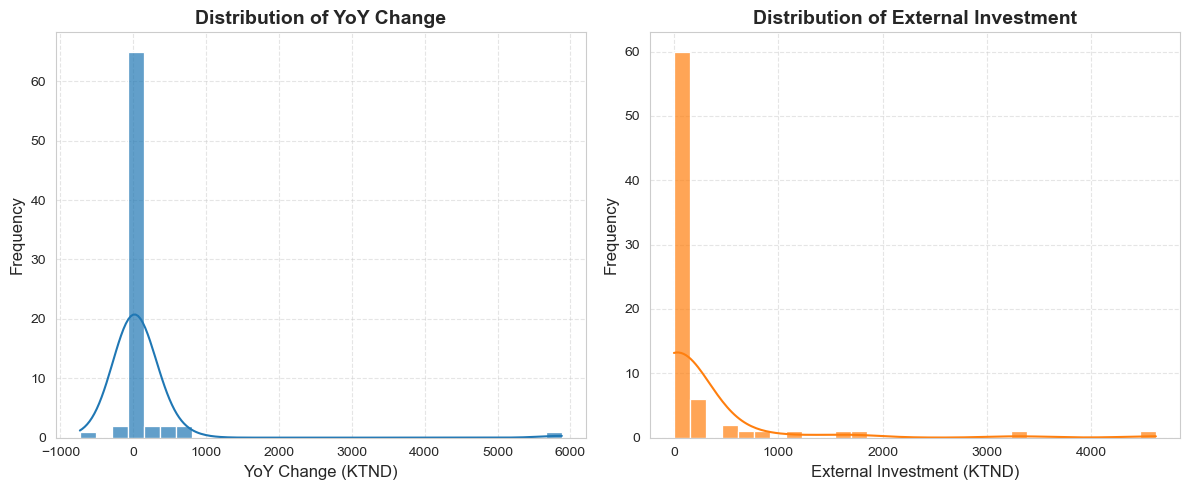

In [13]:

sns.set_style("whitegrid")

#figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#  color palette
colors = ["#1f77b4", "#ff7f0e"]

# Histogram with KDE for YoY Change
sns.histplot(df['YoY_change_KTND'], bins=30, kde=True, color=colors[0], alpha=0.7, ax=ax[0])
ax[0].set_title('Distribution of YoY Change', fontsize=14, fontweight='bold')
ax[0].set_xlabel('YoY Change (KTND)', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.5)

# Histogram with KDE for External Investment
sns.histplot(df['external_investment_1year_after_KTND'], bins=30, kde=True, color=colors[1], alpha=0.7, ax=ax[1])
ax[1].set_title('Distribution of External Investment', fontsize=14, fontweight='bold')
ax[1].set_xlabel('External Investment (KTND)', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.5)

# Improve layout
plt.tight_layout()
plt.savefig('enhanced_target_distributions.png', dpi=300)  # Higher resolution
plt.show()



In [14]:
# Check for zero-inflation in target variables
for target in ['YoY_change_KTND', 'external_investment_1year_after_KTND']:
    zeros = (df[target] == 0).sum()
    print(f"\nZeros in {target}: {zeros} ({zeros/len(df)*100:.2f}%)")


Zeros in YoY_change_KTND: 31 (41.33%)

Zeros in external_investment_1year_after_KTND: 54 (72.00%)


In [15]:
## Correlations 

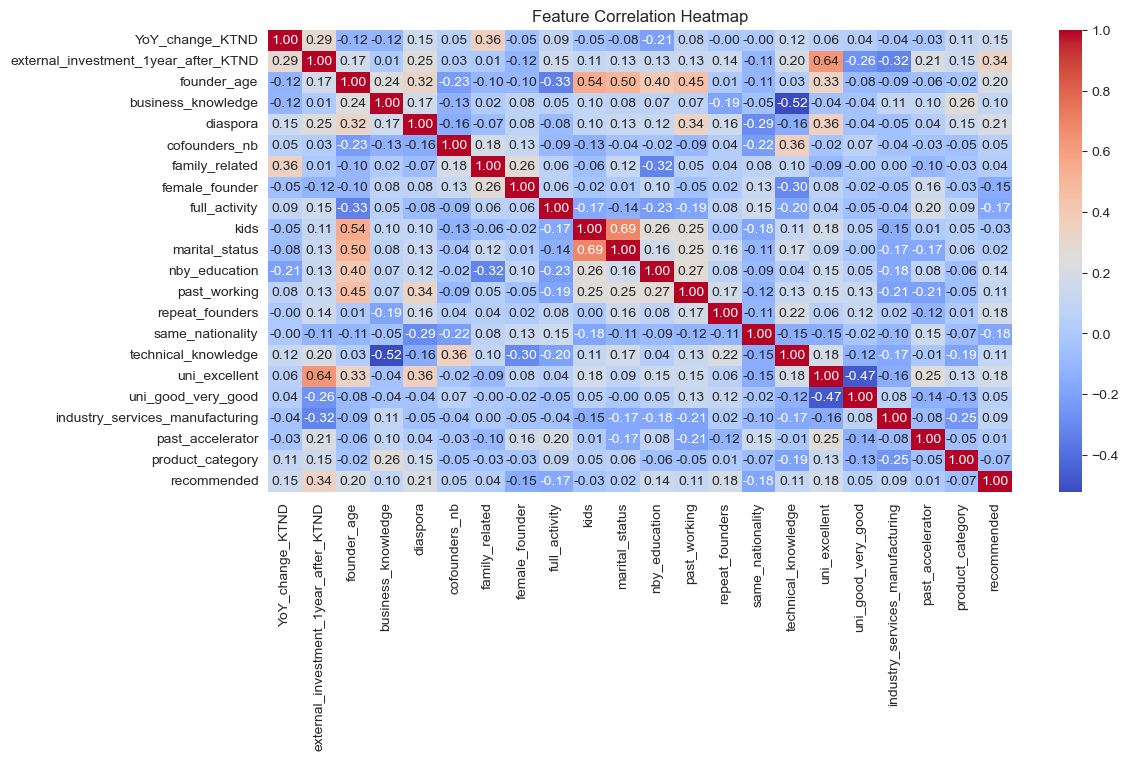

In [16]:
# Correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


Top 5 features correlated with YoY_change_KTND:
family_related: 0.3574
nby_education: -0.2068
recommended: 0.1538
diaspora: 0.1535
technical_knowledge: 0.1210

Top 5 features correlated with external_investment_1year_after_KTND:
uni_excellent: 0.6368
recommended: 0.3391
industry_services_manufacturing: -0.3246
uni_good_very_good: -0.2625
diaspora: 0.2489


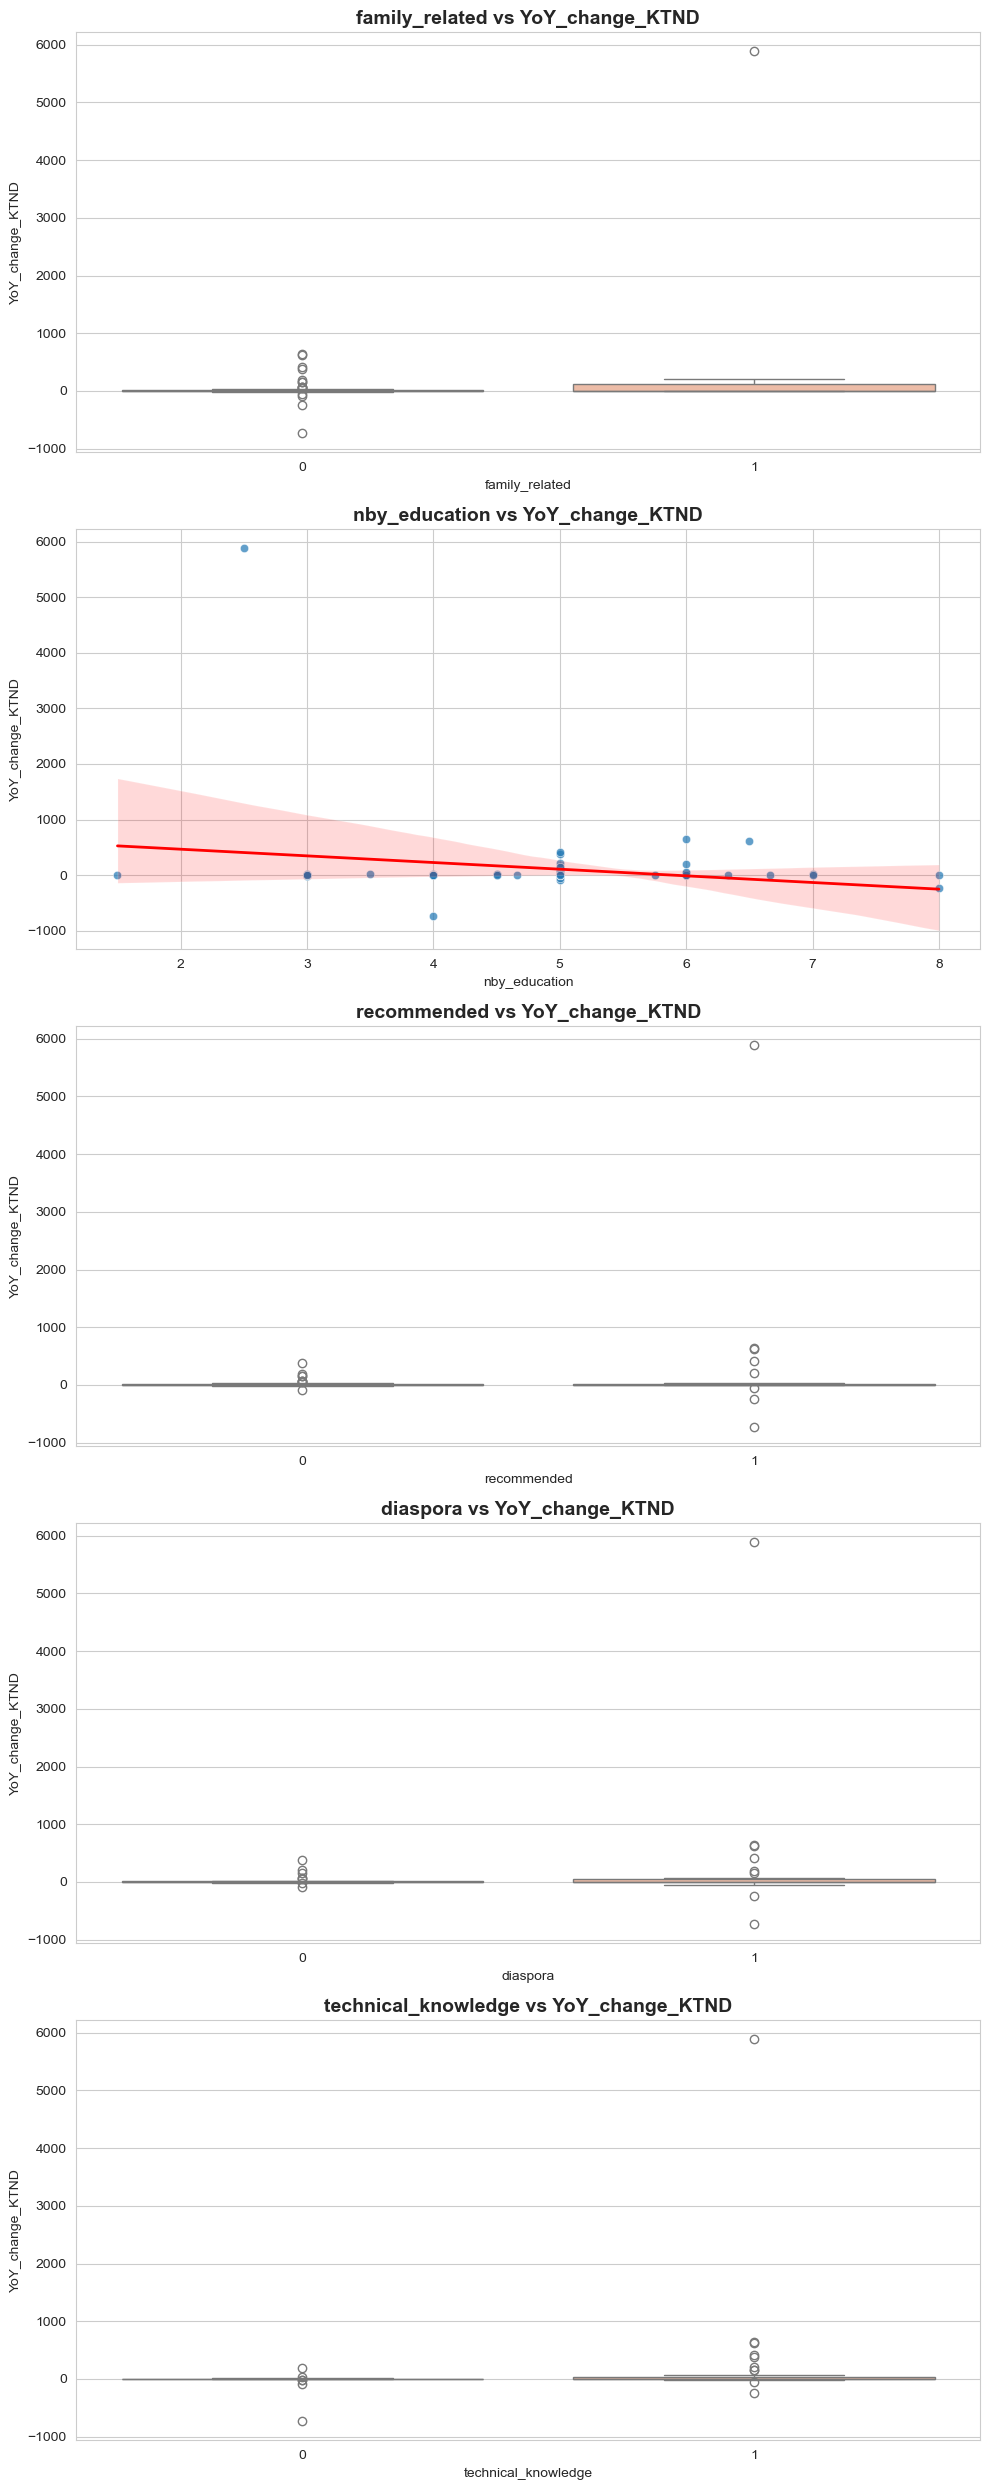

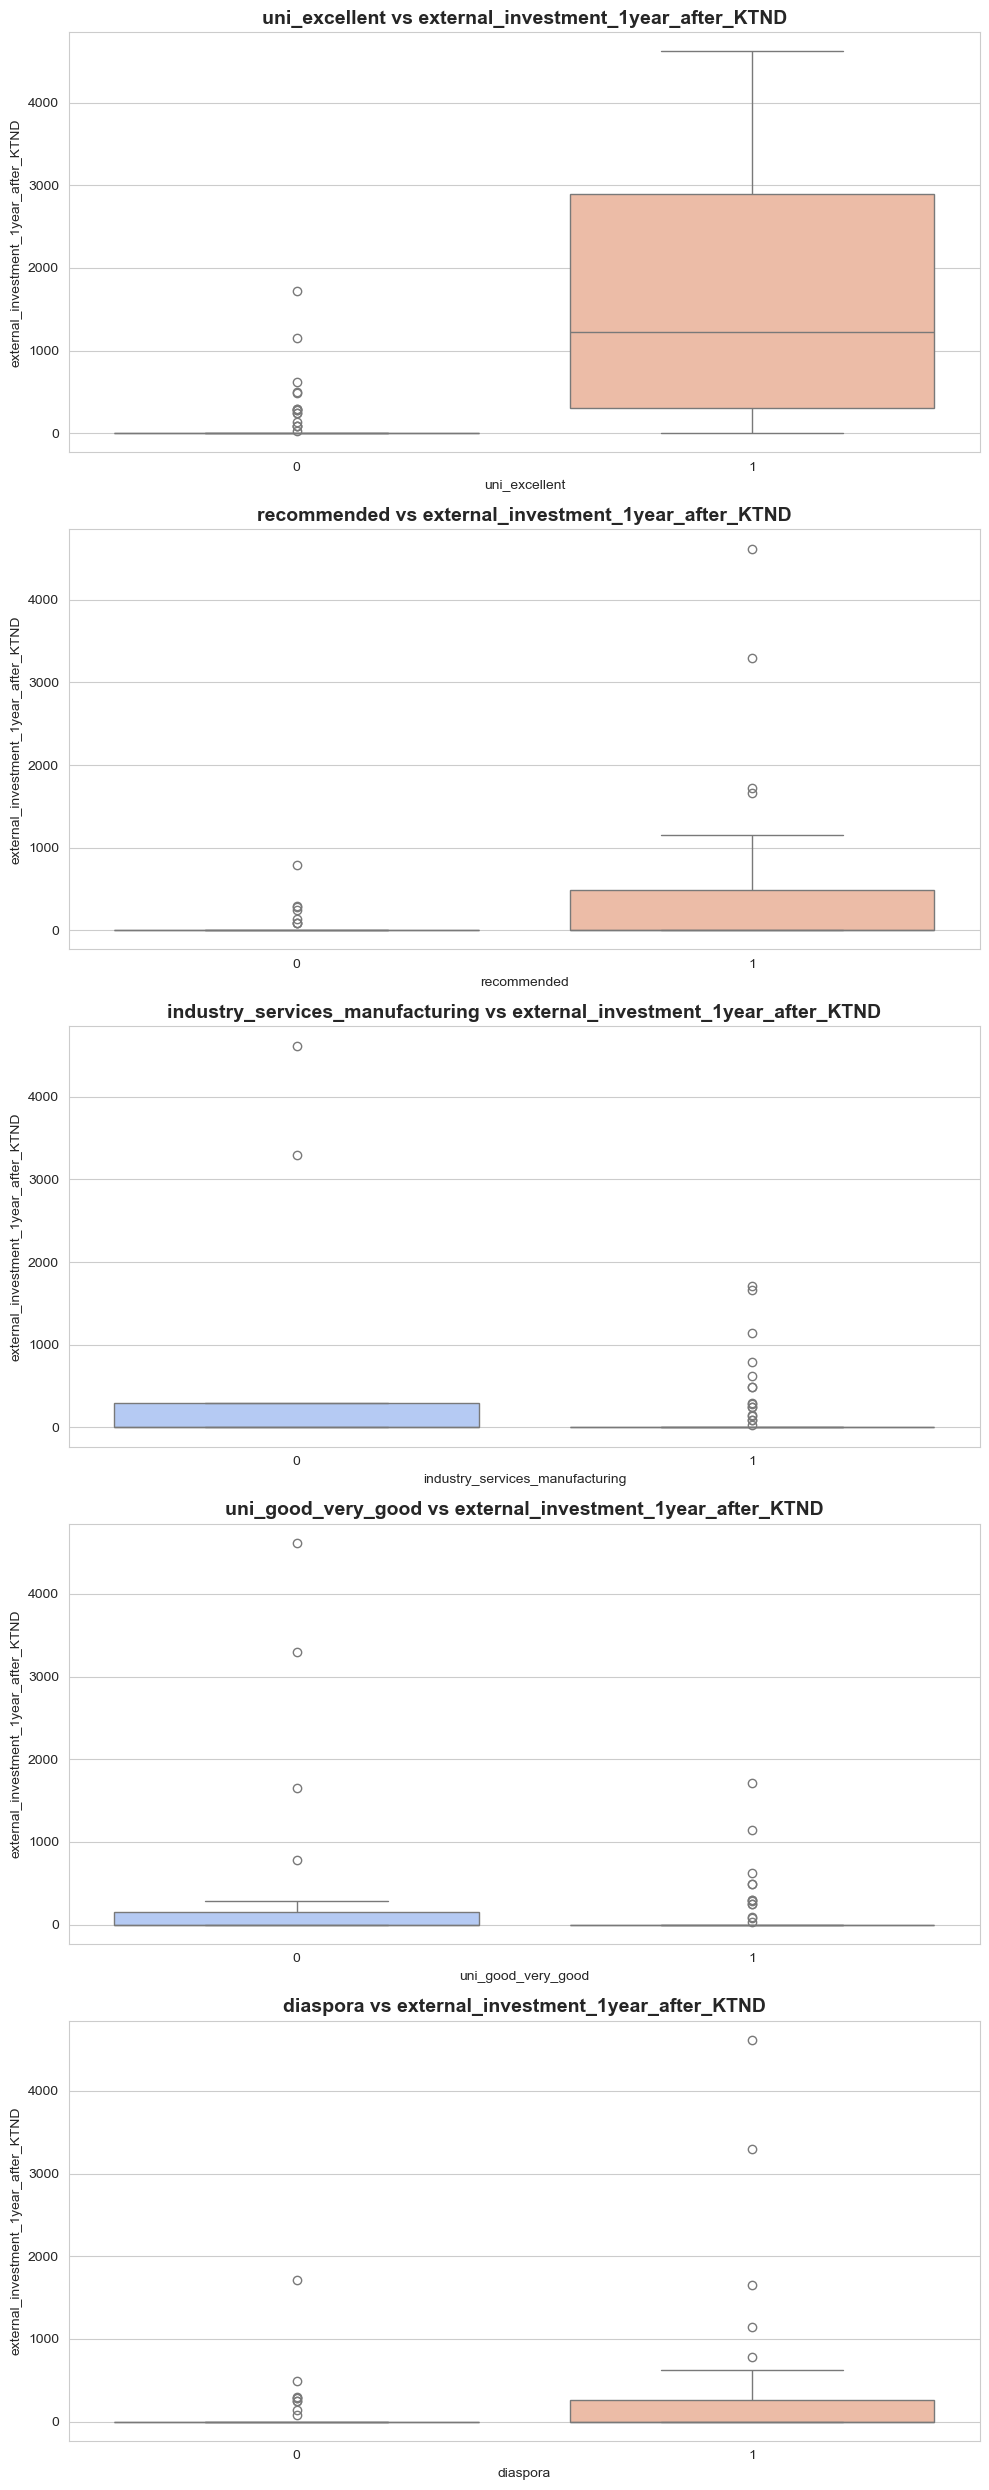

In [17]:
# for better readability
sns.set_style("whitegrid")

# Defining numerical and binary features
numerical_features = ['founder_age', 'cofounders_nb', 'nby_education']
binary_features = [col for col in df.columns if col not in numerical_features +
                   ['YoY_change_KTND', 'external_investment_1year_after_KTND']]

### === 1. Correlation Matrix for Numerical Features === ###
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Numerical Features', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('enhanced_correlation_matrix.png', dpi=300)
plt.close()

### === 2. Correlation with Target Variables === ###
target_corr = pd.DataFrame()

for target in ['YoY_change_KTND', 'external_investment_1year_after_KTND']:
    correlations = {}

    for feature in df.columns:
        if feature not in ['YoY_change_KTND', 'external_investment_1year_after_KTND']:
            corr = df[feature].corr(df[target])
            correlations[feature] = corr

    # Convert to DataFrame, sort by absolute correlation
    sorted_corr = pd.Series(correlations).sort_values(key=abs, ascending=False)
    target_corr[target] = sorted_corr

    # Print top 5 most correlated features
    print(f"\nTop 5 features correlated with {target}:")
    for feature, corr in sorted_corr[:5].items():
        print(f"{feature}: {corr:.4f}")

# Plot feature correlations with target variables
plt.figure(figsize=(12, 6))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlations with Target Variables', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('enhanced_target_correlations.png', dpi=300)
plt.close()

### === 3. Relationship Between Key Features & Targets === ###
for target in ['YoY_change_KTND', 'external_investment_1year_after_KTND']:
    top_features = target_corr[target].abs().nlargest(5).index  # Top 5 correlated features

    fig, axes = plt.subplots(len(top_features), 1, figsize=(10, 5 * len(top_features)))

    for i, feature in enumerate(top_features):
        if feature in numerical_features:
            sns.scatterplot(x=feature, y=target, data=df, ax=axes[i], color="#1f77b4", alpha=0.7)
            sns.regplot(x=feature, y=target, data=df, ax=axes[i], scatter=False, color='red', line_kws={"linewidth": 2})
        else:
            sns.boxplot(x=feature, y=target, data=df, ax=axes[i], hue=feature, palette="coolwarm", legend=False)

        axes[i].set_title(f'{feature} vs {target}', fontsize=14, fontweight='bold')

    plt.tight_layout()

In [18]:
## Data Transformation 


Skewness before and after transformation:
YoY_change_KTND: 7.84 -> 0.49
external_investment_1year_after_KTND: 4.56 -> 0.98


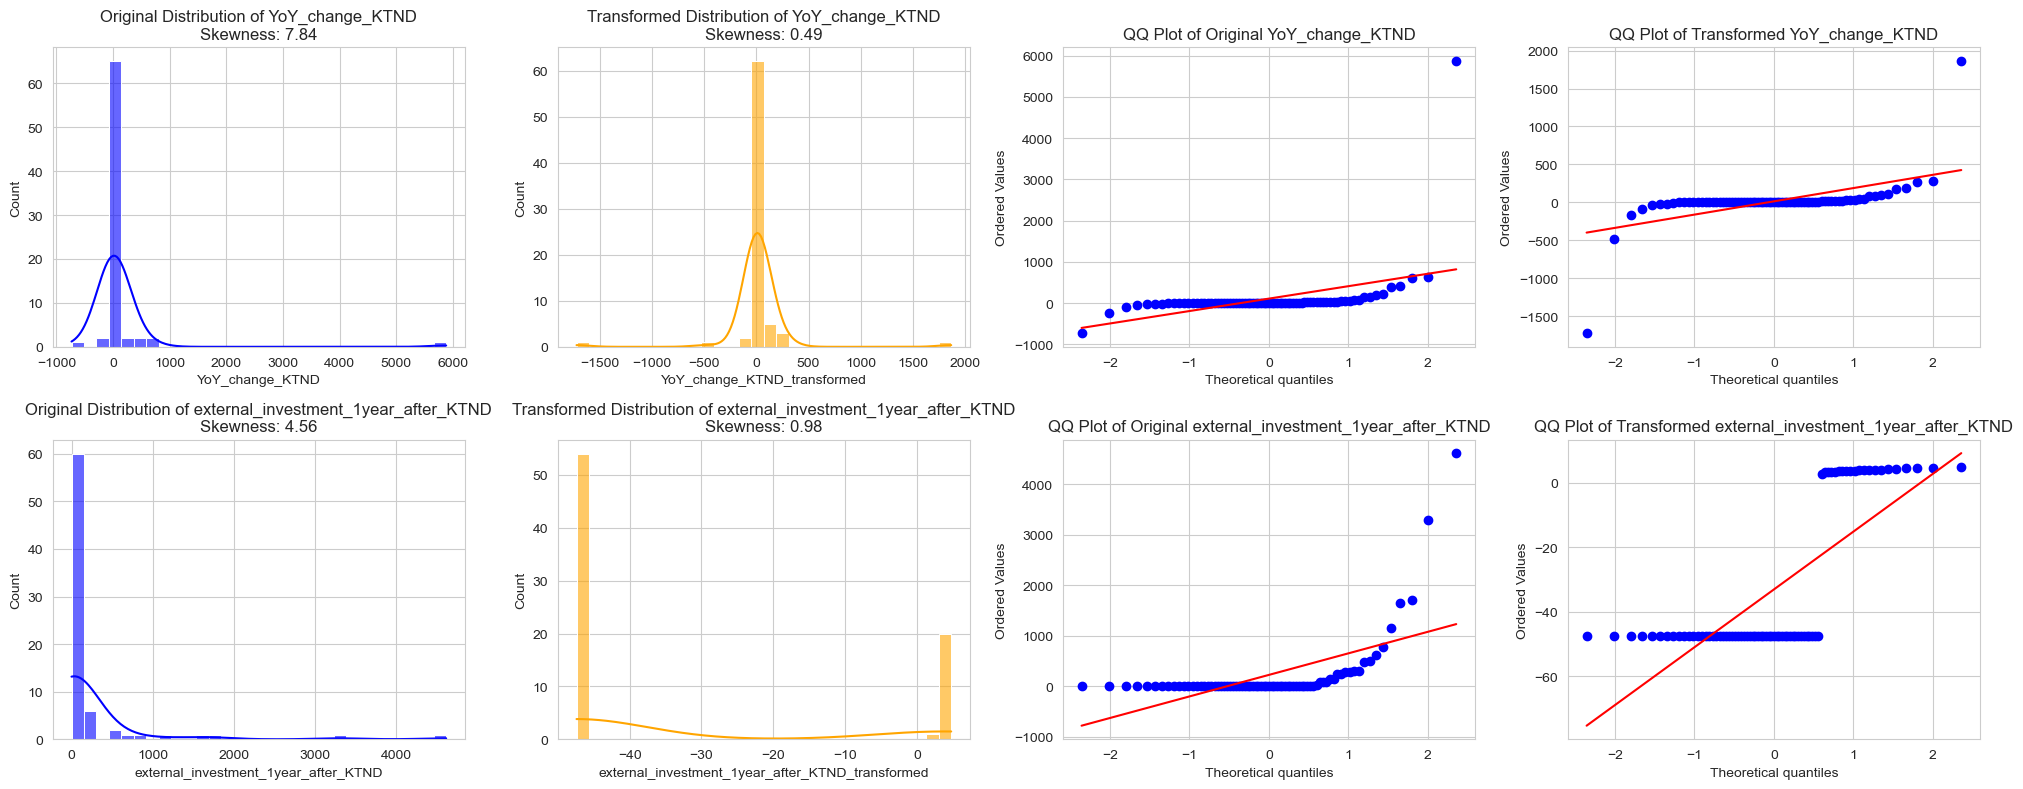

In [19]:

from scipy.stats import yeojohnson, boxcox, skew, probplot

# Defining target variables
target_vars = ['YoY_change_KTND', 'external_investment_1year_after_KTND']

# Copying dataframe to avoid modifying original data
df_transformed = df.copy()

# Applying Yeo-Johnson Transformation to YoY_change_KTND as it contains negative values
df_transformed['YoY_change_KTND_transformed'], _ = yeojohnson(df['YoY_change_KTND'] + 1e-6)

# Applying Box-Cox to external_investment_1year_after_KTND (handling zeros)
df_transformed['external_investment_1year_after_KTND_transformed'], _ = boxcox(df['external_investment_1year_after_KTND'] + 1e-6)

# Check skewness after transformation
print("\nSkewness before and after transformation:")
for var in target_vars:
    transformed_var = f'{var}_transformed'
    original_skewness = skew(df[var])
    transformed_skewness = skew(df_transformed[transformed_var])
    print(f"{var}: {original_skewness:.2f} -> {transformed_skewness:.2f}")

# Visualizations: Histograms & QQ Plots
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

for i, var in enumerate(target_vars):
    transformed_var = f'{var}_transformed'

    # Original Histogram
    sns.histplot(df[var], bins=30, kde=True, ax=axes[i, 0], color="blue", alpha=0.6)
    axes[i, 0].set_title(f'Original Distribution of {var}\nSkewness: {skew(df[var]):.2f}')

    # Transformed Histogram
    sns.histplot(df_transformed[transformed_var], bins=30, kde=True, ax=axes[i, 1], color="orange", alpha=0.6)
    axes[i, 1].set_title(f'Transformed Distribution of {var}\nSkewness: {skew(df_transformed[transformed_var]):.2f}')

    # Original QQ Plot
    probplot(df[var], dist="norm", plot=axes[i, 2])
    axes[i, 2].set_title(f'QQ Plot of Original {var}')

    # Transformed QQ Plot
    probplot(df_transformed[transformed_var], dist="norm", plot=axes[i, 3])
    axes[i, 3].set_title(f'QQ Plot of Transformed {var}')

plt.tight_layout()
plt.show()

# Save transformed dataset
df_transformed.to_csv("transformed_data.csv", index=False)


In [20]:
## Prediction 

In [21]:
## Revenue Growth Prediction :Bayesian Linear Regression

Initializing NUTS using jitter+adapt_diag...
C:\Users\hibaa\anaconda3\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_full_activity, beta_uni_good_very_good, beta_product_category, beta_founder_age, beta_business_knowledge, beta_diaspora, beta_cofounders_nb, beta_family_related, beta_female_founder, beta_kids, beta_marital_status, beta_nby_education, beta_past_working, beta_repeat_founders, beta_same_nationality, beta_technical_knowledge, beta_uni_excellent, beta_industry_services_manufacturing, beta_past_accelerator, beta_recommended, sigma]


Output()

Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 2275 seconds.
C:\Users\hibaa\anaconda3\Lib\site-packages\arviz\plots\traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(
C:\Users\hibaa\AppData\Local\Temp\ipykernel_26988\2879142383.py:57: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


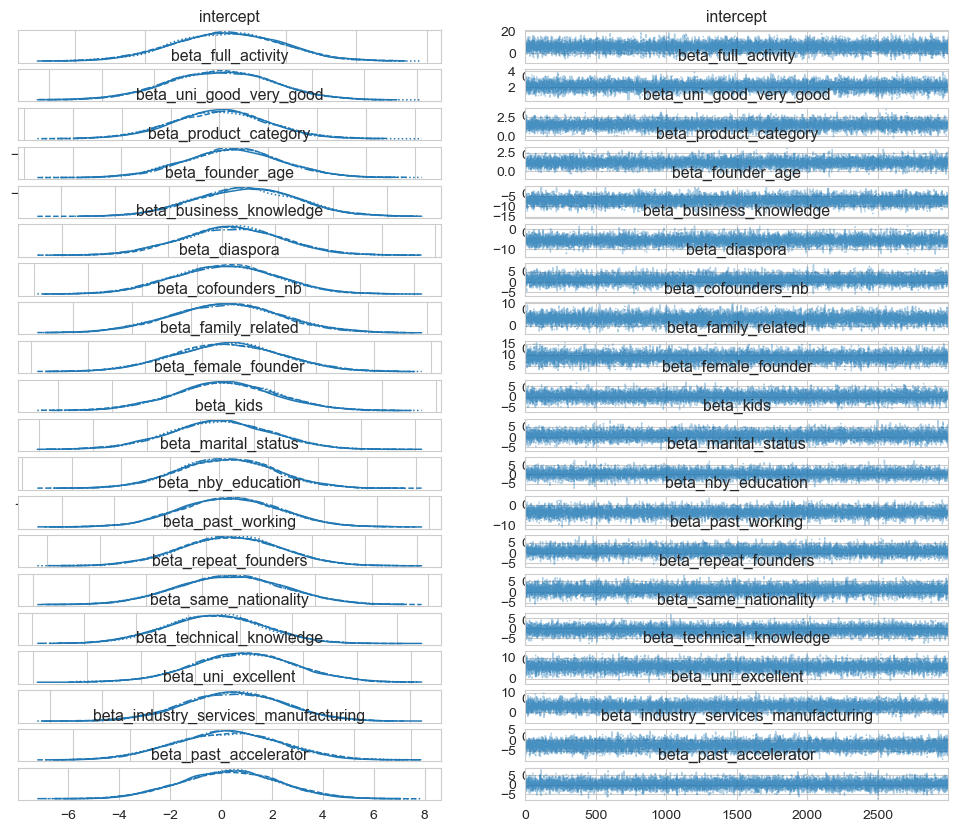

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,5.838,3.806,-1.311,12.906,0.031,0.036,15555.0,8969.0,1.0
beta_full_activity,2.128,0.500,1.196,3.070,0.004,0.005,13845.0,8826.0,1.0
beta_uni_good_very_good,1.508,0.494,0.549,2.423,0.004,0.005,16146.0,9027.0,1.0
beta_product_category,1.145,0.495,0.234,2.094,0.004,0.005,16017.0,9366.0,1.0
beta_founder_age,-7.176,1.881,-10.860,-3.836,0.015,0.017,14873.0,8890.0,1.0
beta_business_knowledge,-5.622,1.894,-8.997,-1.907,0.017,0.018,13184.0,8431.0,1.0
beta_diaspora,1.059,1.902,-2.527,4.557,0.015,0.018,15840.0,8553.0,1.0
beta_cofounders_nb,3.183,1.884,-0.487,6.608,0.016,0.019,13955.0,8733.0,1.0
beta_family_related,8.888,1.904,5.314,12.465,0.015,0.018,15868.0,9572.0,1.0
beta_female_founder,0.166,1.877,-3.404,3.623,0.015,0.018,15604.0,9454.0,1.0


In [22]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv("transformed_data.csv").dropna()  # Drop missing values

# Defining predictors
predictors = ['founder_age', 'business_knowledge', 'diaspora', 'cofounders_nb',
              'family_related', 'female_founder', 'full_activity', 'kids',
              'marital_status', 'nby_education', 'past_working', 'repeat_founders',
              'same_nationality', 'technical_knowledge', 'uni_excellent',
              'uni_good_very_good', 'industry_services_manufacturing',
              'past_accelerator', 'product_category', 'recommended']

X = df[predictors]
y = df['YoY_change_KTND_transformed']

# Standardize predictors
X = (X - X.mean()) / X.std()

# Define model
with pm.Model() as YoY_revenue_model:
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0., sigma=5.)

    # Priors for significant predictors (custom priors)
    beta_full_activity = pm.Normal("beta_full_activity", mu=2.0, sigma=0.5)
    beta_uni_good_very_good = pm.Normal("beta_uni_good_very_good", mu=1.5, sigma=0.5)
    beta_product_category = pm.Normal("beta_product_category", mu=1.0, sigma=0.5)

    # Dynamically create priors for all other predictors
    special_predictors = ['full_activity', 'uni_good_very_good', 'product_category']
    other_predictors = [p for p in predictors if p not in special_predictors]
    betas = {
        p: pm.Normal(f"beta_{p}", mu=0, sigma=2.0)
        for p in other_predictors
    }

    # Linear model
    mu = intercept
    mu += beta_full_activity * X['full_activity']
    mu += beta_uni_good_very_good * X['uni_good_very_good']
    mu += beta_product_category * X['product_category']
    mu += sum(betas[p] * X[p] for p in other_predictors)

    # Likelihood
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # Sampling
    trace_rev = pm.sample(3000, tune=1500, target_accept=0.99, chains=4)

# Plot trace
az.plot_trace(trace_rev, figsize=(12, 10))
plt.tight_layout()
plt.show()

# Summary statistics
az.summary(trace_rev)


In [ ]:
## Interpretation of table results:

# mean : On average, a 1-unit increase in "beta" is associated with a "mean of beta" -unit increase in YoY revenue change

# sd :  There is uncertainty around the mean estimate (mean ± sd).

# HDI highest density interval : There’s a 94% probability the true effect of "beta" lies between hdi_3% and hdi_97%. If the interval excludes 0, the effect is "statistically significant" in a Bayesian sense.

# mcse_mean and mcse_sd: Monte Carlo Standard Error (MCSE) for the mean and standard deviation : The uncertainty in estimating the posterior mean (due to finite MCMC samples) is "mcse_mean", and for the posterior sd, it’s "mcs_sd"; if those values are small relative to the mean/sd, the MCMC approximation is precise.

# Effective Sample Size (ESS) for the central part (ess_bulk) and tails (ess_tail) of the posterior.

# The chains produced ~ess_bulk independent samples for estimating the mean/median and ~ess_tail samples for the tails. ESS > 1,000–4,000 is considered reliable, meaning autocorrelation in the chains is minimal.

# r_hat (1.0): The Gelman-Rubin convergence statistic : A value of 1.0 means the chains have perfectly converged to the same posterior distribution. 1.01 is acceptable but 1 is ideal 

In [ ]:
## Alternatives :

# change domain knowledge based on mean explainability of other betas in the table, and do not account for the overall model accuracy but on individual betas 
# remove outliers from the data 
# try other models 

In [27]:
## Investment Prediction :Bayesian Logistic Regression

Initializing NUTS using jitter+adapt_diag...
C:\Users\hibaa\anaconda3\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_uni_excellent, beta_repeat_founders, beta_recommended, beta_founder_age, beta_business_knowledge, beta_diaspora, beta_cofounders_nb, beta_family_related, beta_female_founder, beta_full_activity, beta_kids, beta_marital_status, beta_nby_education, beta_past_working, beta_same_nationality, beta_technical_knowledge, beta_uni_good_very_good, beta_industry_services_manufacturing, beta_past_accelerator, beta_product_category, intercept]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4908 seconds.
C:\Users\hibaa\anaconda3\Lib\site-packages\arviz\plots\traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(
C:\Users\hibaa\AppData\Local\Temp\ipykernel_26988\1762739993.py:66: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


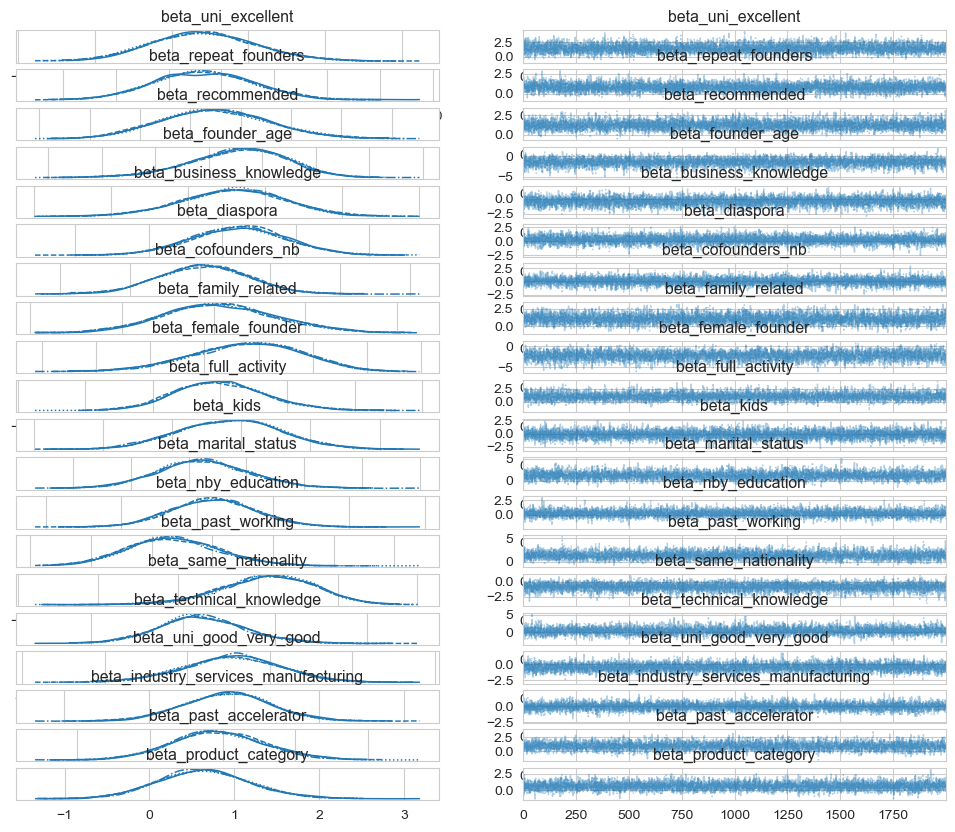

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_uni_excellent,1.423,0.677,0.148,2.689,0.010,0.007,4991.0,5676.0,1.0
beta_repeat_founders,0.837,0.473,-0.034,1.727,0.006,0.005,6708.0,5669.0,1.0
beta_recommended,1.250,0.536,0.277,2.283,0.008,0.005,4459.0,4540.0,1.0
beta_founder_age,-1.448,0.906,-3.138,0.250,0.013,0.010,4922.0,4910.0,1.0
beta_business_knowledge,-0.410,0.665,-1.628,0.878,0.010,0.007,4479.0,5484.0,1.0
beta_diaspora,0.228,0.645,-0.990,1.422,0.008,0.007,6259.0,5522.0,1.0
beta_cofounders_nb,0.057,0.646,-1.159,1.247,0.008,0.007,7005.0,5875.0,1.0
beta_family_related,1.066,0.617,-0.099,2.223,0.009,0.006,4720.0,5420.0,1.0
beta_female_founder,-2.211,1.009,-4.075,-0.342,0.017,0.010,3425.0,5347.0,1.0
beta_full_activity,1.009,0.672,-0.164,2.376,0.009,0.008,5180.0,4762.0,1.0


In [23]:
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv("transformed_data.csv").dropna()

# Define predictors
predictors = ['founder_age', 'business_knowledge', 'diaspora', 'cofounders_nb',
              'family_related', 'female_founder', 'full_activity', 'kids',
              'marital_status', 'nby_education', 'past_working', 'repeat_founders',
              'same_nationality', 'technical_knowledge', 'uni_excellent',
              'uni_good_very_good', 'industry_services_manufacturing',
              'past_accelerator', 'product_category', 'recommended']
X = df[predictors]

# Convert target to binary based on median threshold
threshold = df['external_investment_1year_after_KTND_transformed'].median()
df['investment_binary'] = (df['external_investment_1year_after_KTND_transformed'] > threshold).astype(int)
y = df['investment_binary']

# Standardize predictors
X = (X - X.mean()) / X.std()

# Define Bayesian Logistic Regression model
with pm.Model() as External_investment_model:
    # List of manually specified predictors
    key_predictors = ['uni_excellent', 'repeat_founders', 'recommended']
    
    # Other predictors
    remaining_predictors = [p for p in predictors if p not in key_predictors]

    # Priors for key predictors
    beta_uni_excellent = pm.Normal("beta_uni_excellent", mu=1., sigma=1.)
    beta_repeat_founders = pm.Normal("beta_repeat_founders", mu=1., sigma=1.)
    beta_recommended = pm.Normal("beta_recommended", mu=1., sigma=1.)

    # Priors for other predictors, with individual names
    betas = {
        p: pm.Normal(f"beta_{p}", mu=0, sigma=10.)
        for p in remaining_predictors
    }

    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0., sigma=10.)

    # Linear model
    mu = intercept
    mu += beta_uni_excellent * X['uni_excellent']
    mu += beta_repeat_founders * X['repeat_founders']
    mu += beta_recommended * X['recommended']
    mu += sum(betas[p] * X[p] for p in remaining_predictors)

    # Logistic function for probability
    p = pm.math.sigmoid(mu)

    # Likelihood (Bernoulli distribution)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # Sampling
    trace_inv = pm.sample(2000, tune=1000, target_accept=0.99, init="jitter+adapt_diag", chains=4)

# Plot the trace
az.plot_trace(trace_inv, figsize=(12, 10))
plt.tight_layout()
plt.show()

# Display summary statistics
az.summary(trace_inv)


In [29]:
## Saving Models 

In [24]:

# run after training

import pickle
import pymc as pm
import arviz as az
from pathlib import Path
import pandas as pd

# Create model directory
model_dir = Path("saved_models")
model_dir.mkdir(exist_ok=True)

# Save Revenue Model
az.to_netcdf(trace_rev, model_dir/"revenue_model.nc")
pickle.dump({
    'means': X.mean(),
    'stds': X.std(),
    'predictors': predictors
}, open(model_dir/"revenue_preprocessor.pkl", "wb"))

# Save Investment Model
az.to_netcdf(trace_inv, model_dir/"investment_model.nc")
pickle.dump({
    'means': X.mean(),  # From classification model's X
    'stds': X.std(),
    'predictors': predictors,
    'threshold': threshold
}, open(model_dir/"investment_preprocessor.pkl", "wb"))

In [25]:
# Making Predictions 

Enter values for each predictor (stay within min/max range):


founder_age (22.67 - 58.5):  35
business_knowledge (0 - 1):  1
diaspora (0 - 1):  1
cofounders_nb (1 - 4):  1
family_related (0 - 1):  1
female_founder (0 - 1):  1
full_activity (0 - 1):  1
kids (0 - 1):  1
marital_status (0 - 1):  1
nby_education (1.5 - 8.0):  7
past_working (0 - 1):  1
repeat_founders (0 - 1):  1
same_nationality (0 - 1):  0
technical_knowledge (0 - 1):  1
uni_excellent (0 - 1):  1
uni_good_very_good (0 - 1):  1
industry_services_manufacturing (0 - 1):  1
past_accelerator (0 - 1):  0
product_category (0 - 1):  1
recommended (0 - 1):  1



📊 Bayesian Predictions:
• YoY Change: 13.2K (±8.8K)
  89% HDI: 4.8K to 22.0K

• Investment Probability: 99.1%
  89% HDI: 99.6% to 100.0%
  Predicted Class: High confidence


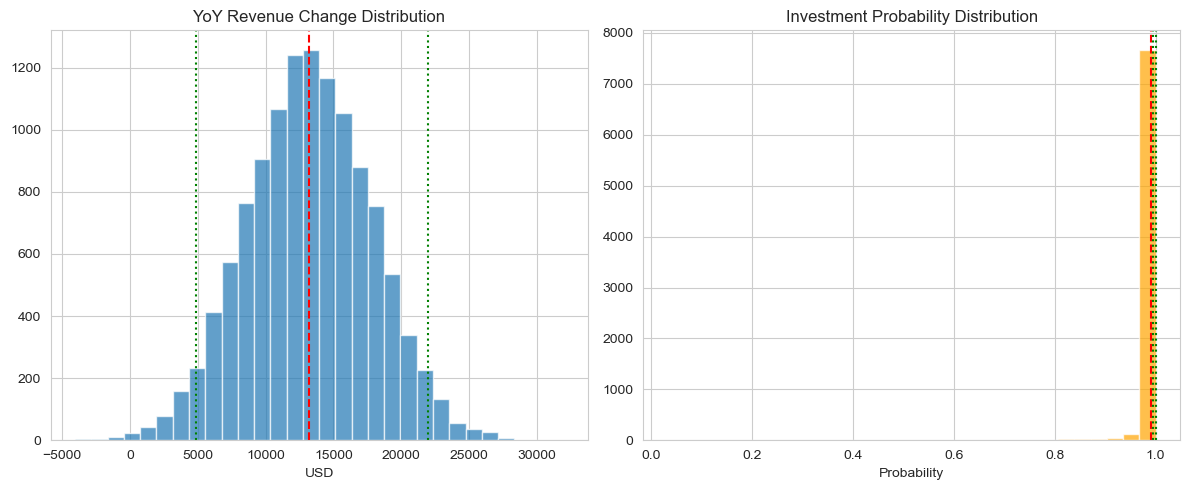

In [26]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Load dataset and define predictors
df_original = pd.read_csv("transformed_data.csv").dropna()
predictors = [
    'founder_age', 'business_knowledge', 'diaspora', 'cofounders_nb',
    'family_related', 'female_founder', 'full_activity', 'kids',
    'marital_status', 'nby_education', 'past_working', 'repeat_founders',
    'same_nationality', 'technical_knowledge', 'uni_excellent',
    'uni_good_very_good', 'industry_services_manufacturing',
    'past_accelerator', 'product_category', 'recommended'
]

# Compute standardization parameters
X_train = df_original[predictors]
train_mean = X_train.mean()
train_std = X_train.std()

# Collect user input
input_data = {}
print("Enter values for each predictor (stay within min/max range):")
for predictor in predictors:
    min_val = df_original[predictor].min()
    max_val = df_original[predictor].max()
    
    while True:
        try:
            value = float(input(f"{predictor} ({min_val} - {max_val}): "))
            if min_val <= value <= max_val:
                input_data[predictor] = value
                break
            else:
                print(f"⚠️ Value must be between {min_val} and {max_val}. Try again.")
        except ValueError:
            print("❌ Invalid input. Please enter a numerical value.")

# Prediction functions
def predict_yoy_revenue(trace, new_data, X_mean, X_std):
    new_df = pd.DataFrame([new_data])
    new_df_std = (new_df - X_mean) / X_std

    intercept = trace.posterior['intercept'].values.flatten()

    # Special predictors
    beta_full = trace.posterior['beta_full_activity'].values.flatten()
    beta_uni = trace.posterior['beta_uni_good_very_good'].values.flatten()
    beta_prod = trace.posterior['beta_product_category'].values.flatten()

    # Get dynamic beta values for all other predictors
    special_predictors = ['full_activity', 'uni_good_very_good', 'product_category']
    other_predictors = [p for p in X_mean.index if p not in special_predictors]

    beta_other = np.stack([
        trace.posterior[f"beta_{p}"].values.flatten()
        for p in other_predictors
    ], axis=1)  # Shape: (n_samples, n_other_predictors)

    # Prepare X values in the same order as betas
    X_other = new_df_std[other_predictors].values.flatten()

    # Dot product of beta_other (n_samples, n_other) with X_other (n_other,)
    mu_samples = (
        intercept +
        beta_full * new_df_std['full_activity'].item() +
        beta_uni * new_df_std['uni_good_very_good'].item() +
        beta_prod * new_df_std['product_category'].item() +
        np.dot(beta_other, X_other)
    )

    return {
        'samples': mu_samples,
        'mean': np.mean(mu_samples),
        'hdi': az.hdi(mu_samples, hdi_prob=0.89)
    }


def predict_investment(trace, new_data, X_mean, X_std):
    """Predict investment probability using Bayesian model"""
    new_df = pd.DataFrame([new_data])
    new_df_std = (new_df - X_mean) / X_std

    intercept = trace.posterior['intercept'].values.flatten()

    # Special predictors (removed 'diaspora')
    beta_uni = trace.posterior['beta_uni_excellent'].values.flatten()
    beta_rep = trace.posterior['beta_repeat_founders'].values.flatten()
    beta_rec = trace.posterior['beta_recommended'].values.flatten()

    # Define special and other predictors
    special_predictors = ['uni_excellent', 'repeat_founders', 'recommended']
    other_predictors = [p for p in X_mean.index if p not in special_predictors]

    # Dynamically stack betas for other predictors
    beta_other = np.stack([
        trace.posterior[f"beta_{p}"].values.flatten()
        for p in other_predictors
    ], axis=1)

    # Extract corresponding standardized X values
    X_other = new_df_std[other_predictors].values.flatten()

    # Compute logit predictions
    logit_samples = (
        intercept +
        beta_uni * new_df_std['uni_excellent'].item() +
        beta_rep * new_df_std['repeat_founders'].item() +
        beta_rec * new_df_std['recommended'].item() +
        np.dot(beta_other, X_other)
    )

    # Convert logits to probabilities
    prob_samples = 1 / (1 + np.exp(-logit_samples))

    return {
        'samples': prob_samples,
        'mean': np.mean(prob_samples),
        'hdi': az.hdi(prob_samples, hdi_prob=0.89),
        'class': 1 if np.mean(prob_samples) > 0.5 else 0
    }


# Make predictions
yoy_result = predict_yoy_revenue(trace_rev, input_data, train_mean, train_std)
inv_result = predict_investment(trace_inv, input_data, train_mean, train_std)

# Convert to original units
yoy_original = (yoy_result['samples'] * df_original['YoY_change_KTND_transformed'].std()
                + df_original['YoY_change_KTND_transformed'].mean())

# Display results
print("\n📊 Bayesian Predictions:")
print(f"• YoY Change: {yoy_original.mean()/1000:.1f}K (±{az.hdi(yoy_original)[1]/1000 - yoy_original.mean()/1000:.1f}K)")
print(f"  89% HDI: {az.hdi(yoy_original)[0]/1000:.1f}K to {az.hdi(yoy_original)[1]/1000:.1f}K")

print(f"\n• Investment Probability: {inv_result['mean']:.1%}")
print(f"  89% HDI: {inv_result['hdi'][0]:.1%} to {inv_result['hdi'][1]:.1%}")
print(f"  Predicted Class: {'High' if inv_result['class'] else 'Low'} confidence")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(yoy_original, bins=30, alpha=0.7)
ax1.set_title('YoY Revenue Change Distribution')
ax1.set_xlabel('USD')
ax1.axvline(yoy_original.mean(), color='red', linestyle='--')
ax1.axvline(az.hdi(yoy_original)[0], color='green', linestyle=':')
ax1.axvline(az.hdi(yoy_original)[1], color='green', linestyle=':')

ax2.hist(inv_result['samples'], bins=30, alpha=0.7, color='orange')
ax2.set_title('Investment Probability Distribution')
ax2.set_xlabel('Probability')
ax2.axvline(inv_result['mean'], color='red', linestyle='--')
ax2.axvline(inv_result['hdi'][0], color='green', linestyle=':')
ax2.axvline(inv_result['hdi'][1], color='green', linestyle=':')

plt.tight_layout()
plt.show()


In [27]:
## Revenue : The model is cautious needing improvments, provides useful estimates, but with moderate uncertainty.The histogram is roughly symmetric with a small positive skew. The red dashed line marks the mean prediction. Green dashed lines are 89% HDI bounds.
## Investment : The model is reliable. The distribution is sharply concentrated near 1.0, with very low spread (predictions do not vary much and are clustered tightly together).The tight HDI (above 90%) shows strong certainty.The signal-to-noise is good (the model is picking up clear patterns)

In [28]:
## model Evaluation 

In [29]:
## R-hat (Convergence Check): Ensure all R-hat values are close to 1 (≤ 1.01), which indicates good convergence and verify that  MCMC chains have properly converged to the posterior distribution.

In [30]:
print("R-hat values for YoY revenue model:")
print(az.rhat(trace_rev))

print("\nR-hat values for Investment model:")
print(az.rhat(trace_inv))


R-hat values for YoY revenue model:
<xarray.Dataset>
Dimensions:                               ()
Data variables: (12/22)
    intercept                             float64 0.9999
    beta_full_activity                    float64 1.0
    beta_uni_good_very_good               float64 1.001
    beta_product_category                 float64 1.0
    beta_founder_age                      float64 1.0
    beta_business_knowledge               float64 1.001
    ...                                    ...
    beta_technical_knowledge              float64 1.001
    beta_uni_excellent                    float64 1.0
    beta_industry_services_manufacturing  float64 1.001
    beta_past_accelerator                 float64 1.001
    beta_recommended                      float64 1.001
    sigma                                 float64 1.001

R-hat values for Investment model:
<xarray.Dataset>
Dimensions:                               ()
Data variables: (12/21)
    beta_uni_excellent                    fl

In [31]:
## Effective Sample Size (ESS) (a low value indicates sampling issues)

In [32]:
print("ESS for YoY revenue model:")
print(az.ess(trace_rev))

print("\nESS for Investment model:")
print(az.ess(trace_inv))


ESS for YoY revenue model:
<xarray.Dataset>
Dimensions:                               ()
Data variables: (12/22)
    intercept                             float64 1.555e+04
    beta_full_activity                    float64 1.384e+04
    beta_uni_good_very_good               float64 1.615e+04
    beta_product_category                 float64 1.602e+04
    beta_founder_age                      float64 1.487e+04
    beta_business_knowledge               float64 1.318e+04
    ...                                    ...
    beta_technical_knowledge              float64 1.467e+04
    beta_uni_excellent                    float64 1.595e+04
    beta_industry_services_manufacturing  float64 1.562e+04
    beta_past_accelerator                 float64 1.581e+04
    beta_recommended                      float64 1.561e+04
    sigma                                 float64 1.56e+04

ESS for Investment model:
<xarray.Dataset>
Dimensions:                               ()
Data variables: (12/21)
    beta

In [33]:
## Evaluating revenue model performance

C:\Users\hibaa\anaconda3\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sampling: [y_obs]


Output()

✅ Mean Squared Error (MSE) (posterior distribution): 3010.98
✅ Mean Absolute Error (MAE) (posterior distribution): 43.76
✅ Mean Squared Error (MSE) (point estimate): 391.39
✅ Mean Absolute Error (MAE) (point estimate): 15.32
✅ R² (point estimate): -1940.42
✅ RMSE (point estimate): 19.78


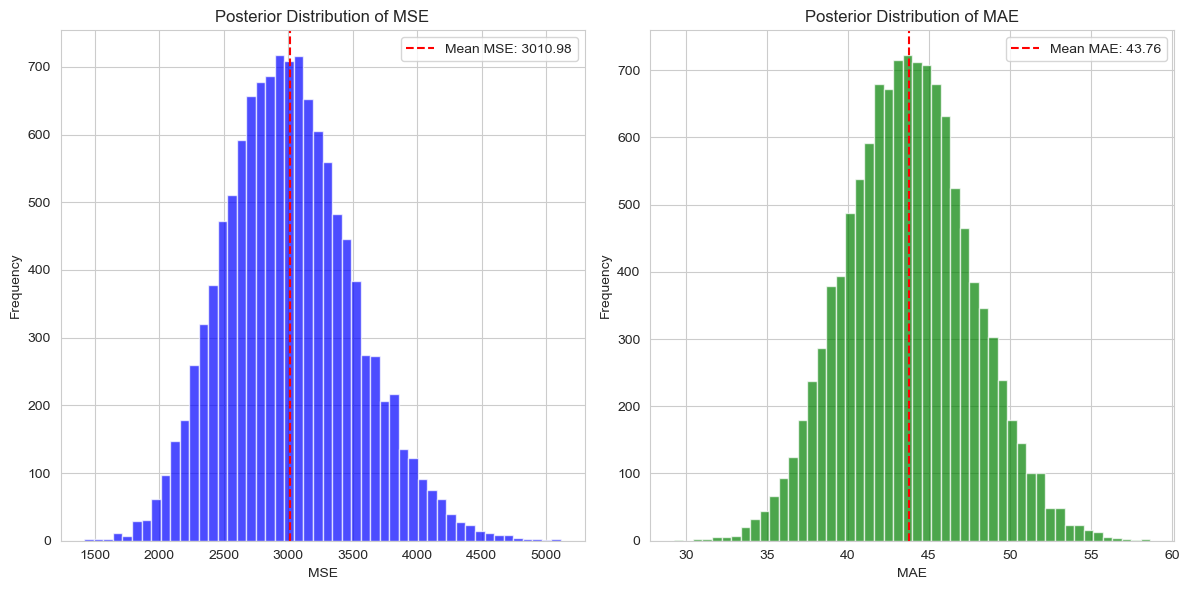


Bayesian R²:
Mean: 0.500
Std: 0.000
94% HDI: [0.500, 0.501]


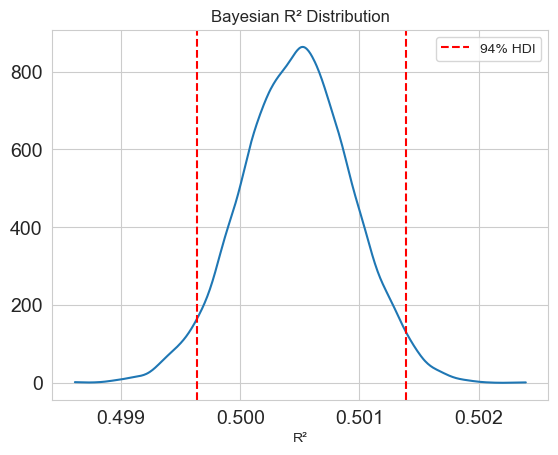

In [34]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the trace from your existing model
# Assuming 'new_trace_rev' is your trace object from the model
# and 'y' is your observed data (length n_obs)

# 1. Generate posterior predictive samples
with YoY_revenue_model:
    posterior_pred = pm.sample_posterior_predictive(trace_rev, var_names=["y_obs"], return_inferencedata=False)

# 2. Reshape posterior predictions to (samples, observations)
y_pred_samples = posterior_pred["y_obs"].reshape(-1, posterior_pred["y_obs"].shape[-1])

# 3. Ensure the observed data (y) is a numpy array
y_array = np.asarray(y)
y_broadcasted = np.broadcast_to(y_array, y_pred_samples.shape)

# 4. Calculate MSE for each posterior sample
mse_samples = np.mean((y_pred_samples - y_broadcasted) ** 2, axis=1)

# 5. Calculate MAE for each posterior sample
mae_samples = np.mean(np.abs(y_pred_samples - y_broadcasted), axis=1)

# 6. Calculate mean MSE and MAE
mean_mse = np.mean(mse_samples)
mean_mae = np.mean(mae_samples)

# 7. Print MSE and MAE for the entire posterior distribution
print(f"✅ Mean Squared Error (MSE) (posterior distribution): {mean_mse:.2f}")
print(f"✅ Mean Absolute Error (MAE) (posterior distribution): {mean_mae:.2f}")

# 8. Classical evaluation metrics (mean prediction as point estimate)
y_pred_mean = y_pred_samples.mean(axis=0)  # Mean over all posterior samples

# Classical MSE and MAE (point estimate)
mse_point_estimate = mean_squared_error(y, y_pred_mean)
mae_point_estimate = mean_absolute_error(y, y_pred_mean)

# Classical R² and RMSE (point estimate)
r2_point_estimate = r2_score(y, y_pred_mean)
rmse_point_estimate = np.sqrt(mse_point_estimate)

print(f"✅ Mean Squared Error (MSE) (point estimate): {mse_point_estimate:.2f}")
print(f"✅ Mean Absolute Error (MAE) (point estimate): {mae_point_estimate:.2f}")
print(f"✅ R² (point estimate): {r2_point_estimate:.2f}")
print(f"✅ RMSE (point estimate): {rmse_point_estimate:.2f}")

# 9. Plot the posterior distribution of MSE and MAE
plt.figure(figsize=(12, 6))

# MSE distribution plot
plt.subplot(1, 2, 1)
plt.hist(mse_samples, bins=50, color='blue', alpha=0.7)
plt.axvline(mean_mse, color='red', linestyle='--', label=f'Mean MSE: {mean_mse:.2f}')
plt.title('Posterior Distribution of MSE')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.legend()

# MAE distribution plot
plt.subplot(1, 2, 2)
plt.hist(mae_samples, bins=50, color='green', alpha=0.7)
plt.axvline(mean_mae, color='red', linestyle='--', label=f'Mean MAE: {mean_mae:.2f}')
plt.title('Posterior Distribution of MAE')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# 10. Bayesian R² calculation (same as before)
y_broadcasted = np.broadcast_to(y_array, y_pred_samples.shape)
bayes_r2_samples = az.r2_samples(y_broadcasted, y_pred_samples)

bayes_r2_mean = bayes_r2_samples.mean()
bayes_r2_std = bayes_r2_samples.std()
bayes_r2_hdi = az.hdi(bayes_r2_samples, hdi_prob=0.94)

print("\nBayesian R²:")
print(f"Mean: {bayes_r2_mean:.3f}")
print(f"Std: {bayes_r2_std:.3f}")
print(f"94% HDI: [{bayes_r2_hdi[0]:.3f}, {bayes_r2_hdi[1]:.3f}]")

# 11. Plot Bayesian R² distribution
az.plot_dist(bayes_r2_samples)
plt.axvline(bayes_r2_hdi[0], color='red', linestyle='--', label='94% HDI')
plt.axvline(bayes_r2_hdi[1], color='red', linestyle='--')
plt.title('Bayesian R² Distribution')
plt.xlabel('R²')
plt.legend()
plt.show()


In [35]:
hdi = az.hdi(posterior_pred["y_obs"], hdi_prob=0.9)
coverage = ((y >= hdi[:, 0]) & (y <= hdi[:, 1])).mean()
print(f"Coverage (90% interval): {coverage:.2%}")


Coverage (90% interval): 100.00%


In [36]:
## Evaluating posterior distributions (checking the model fit)

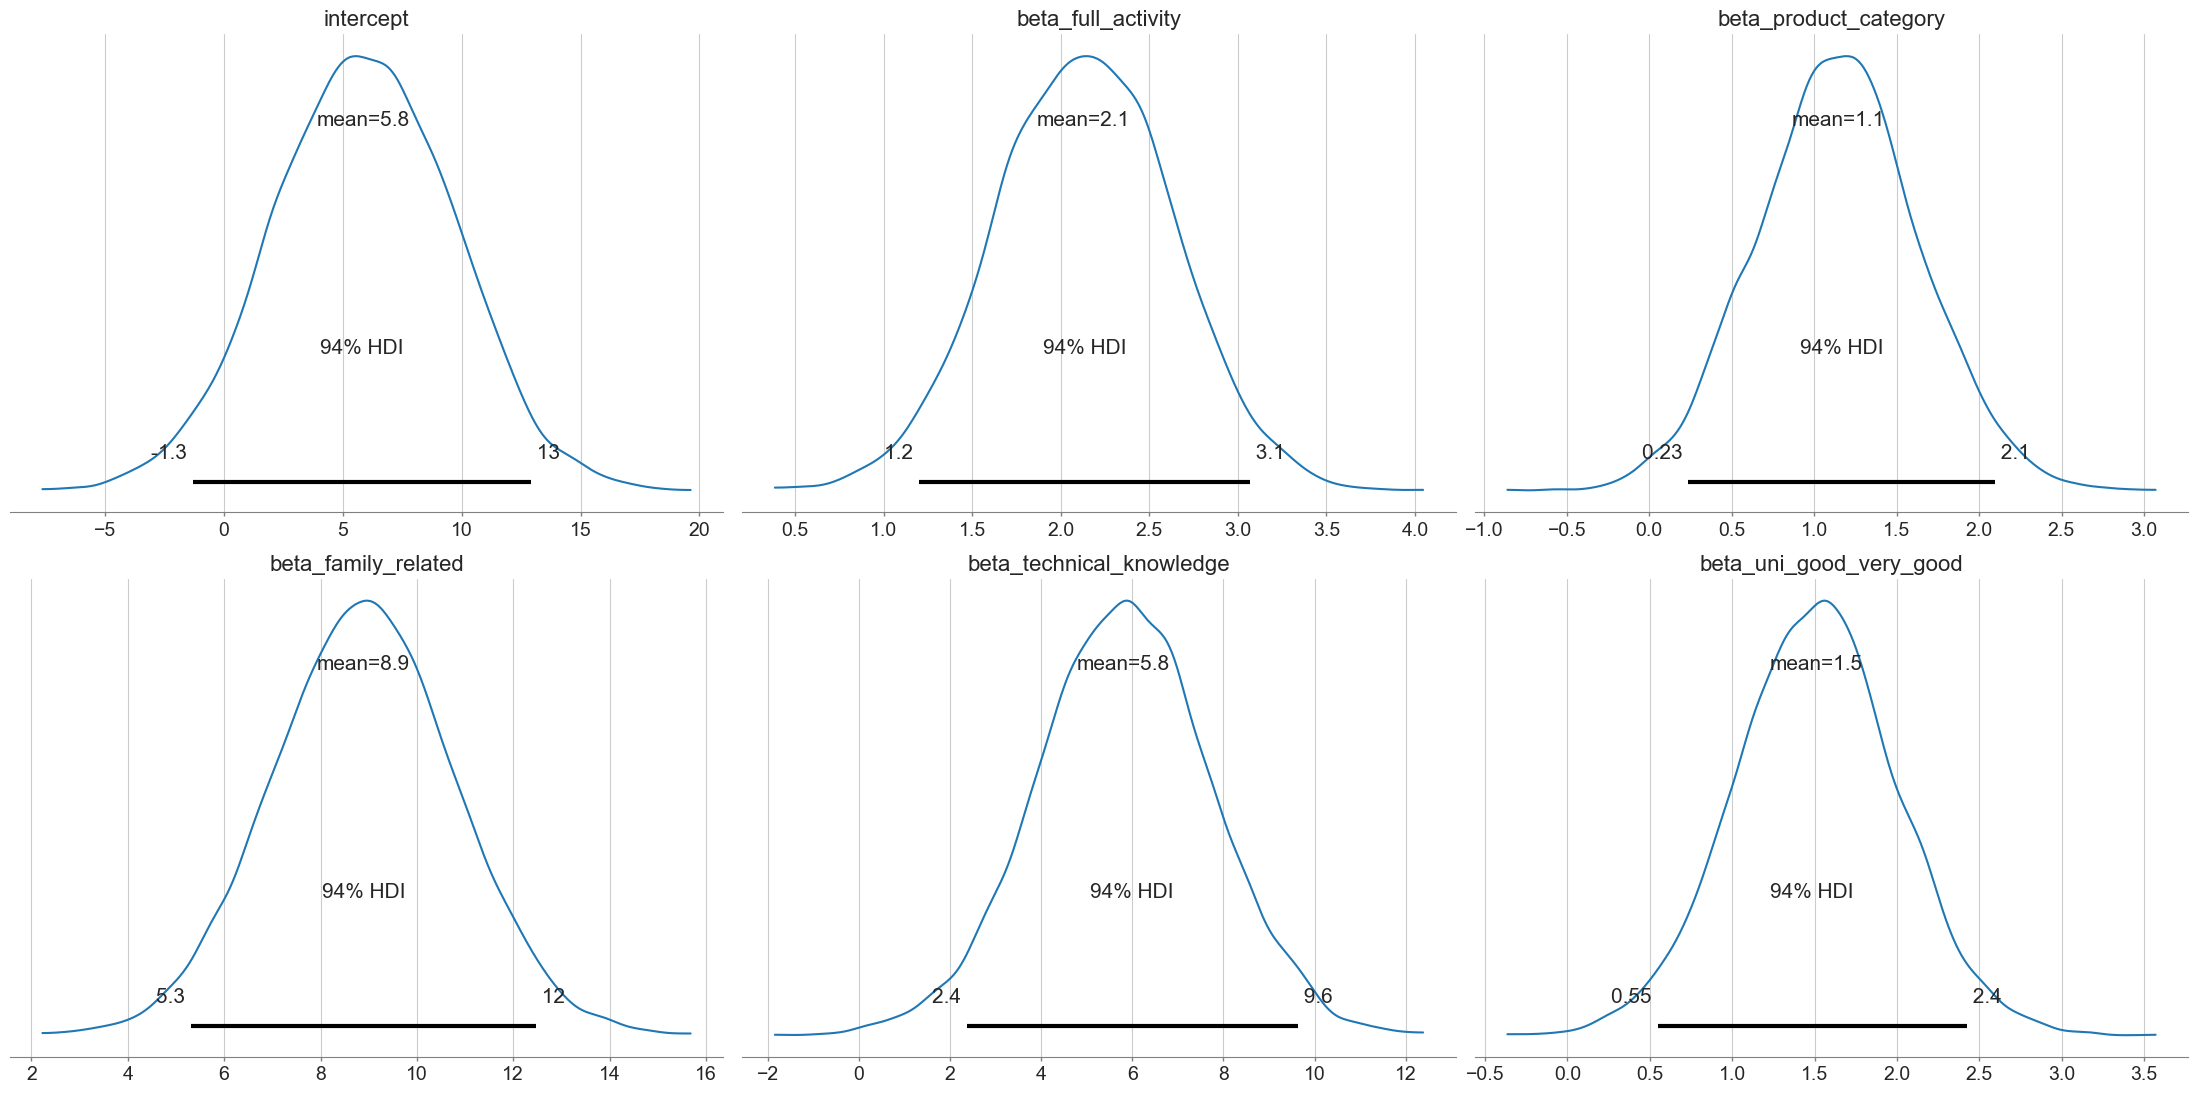

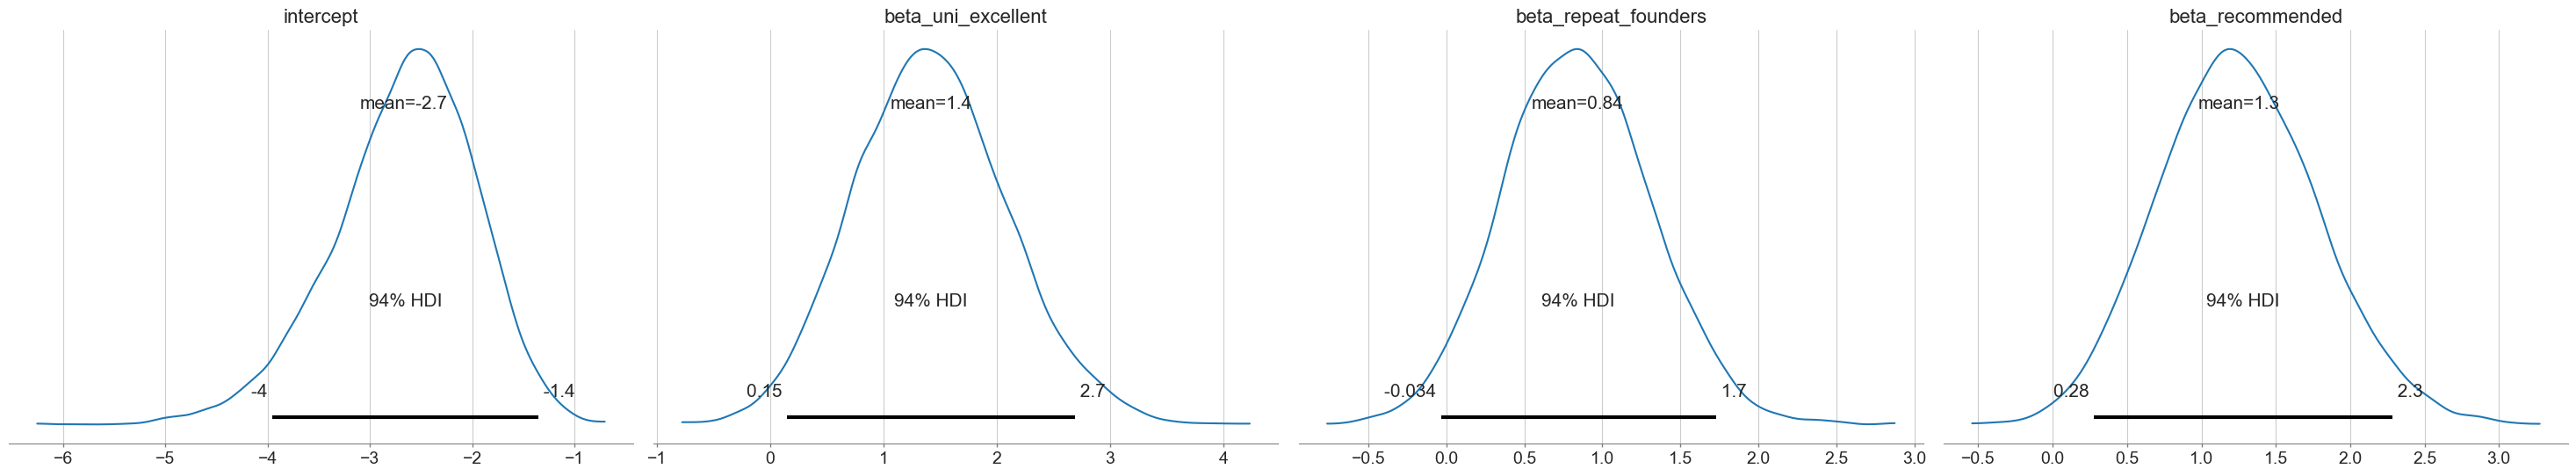

In [37]:
# For the first plot
az.plot_posterior(trace_rev, var_names=['intercept', 'beta_full_activity', 'beta_product_category','beta_family_related', 'beta_technical_knowledge', 'beta_uni_good_very_good'])
plt.tight_layout()  # Ensures all elements fit properly
plt.savefig('posterior plot_baseline revenue model.png', dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()

# For the second plot
az.plot_posterior(trace_inv, var_names=['intercept', 'beta_uni_excellent', 'beta_repeat_founders','beta_recommended'])
plt.tight_layout()  # Ensures all elements fit properly
plt.savefig('posterior plot_investment status model.png', dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()

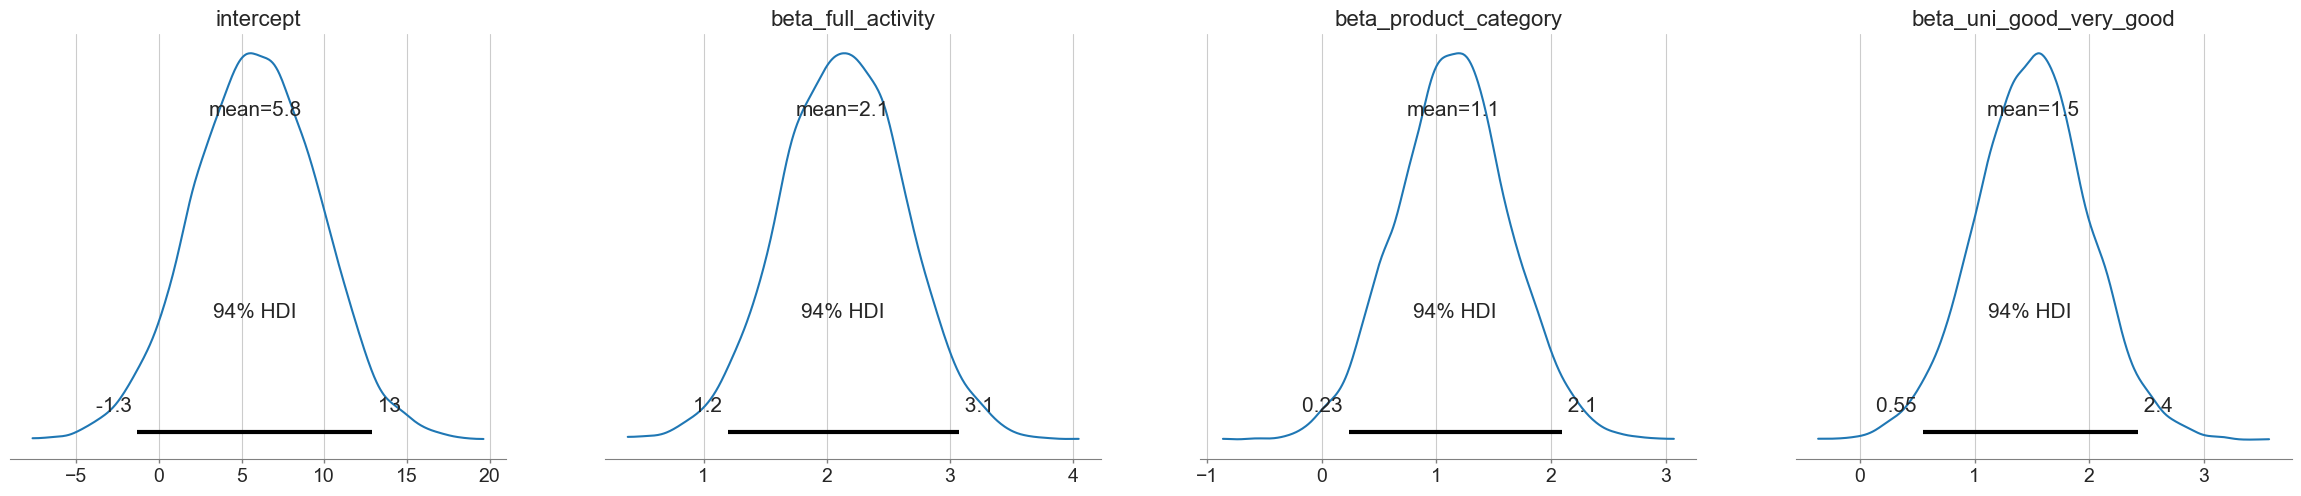

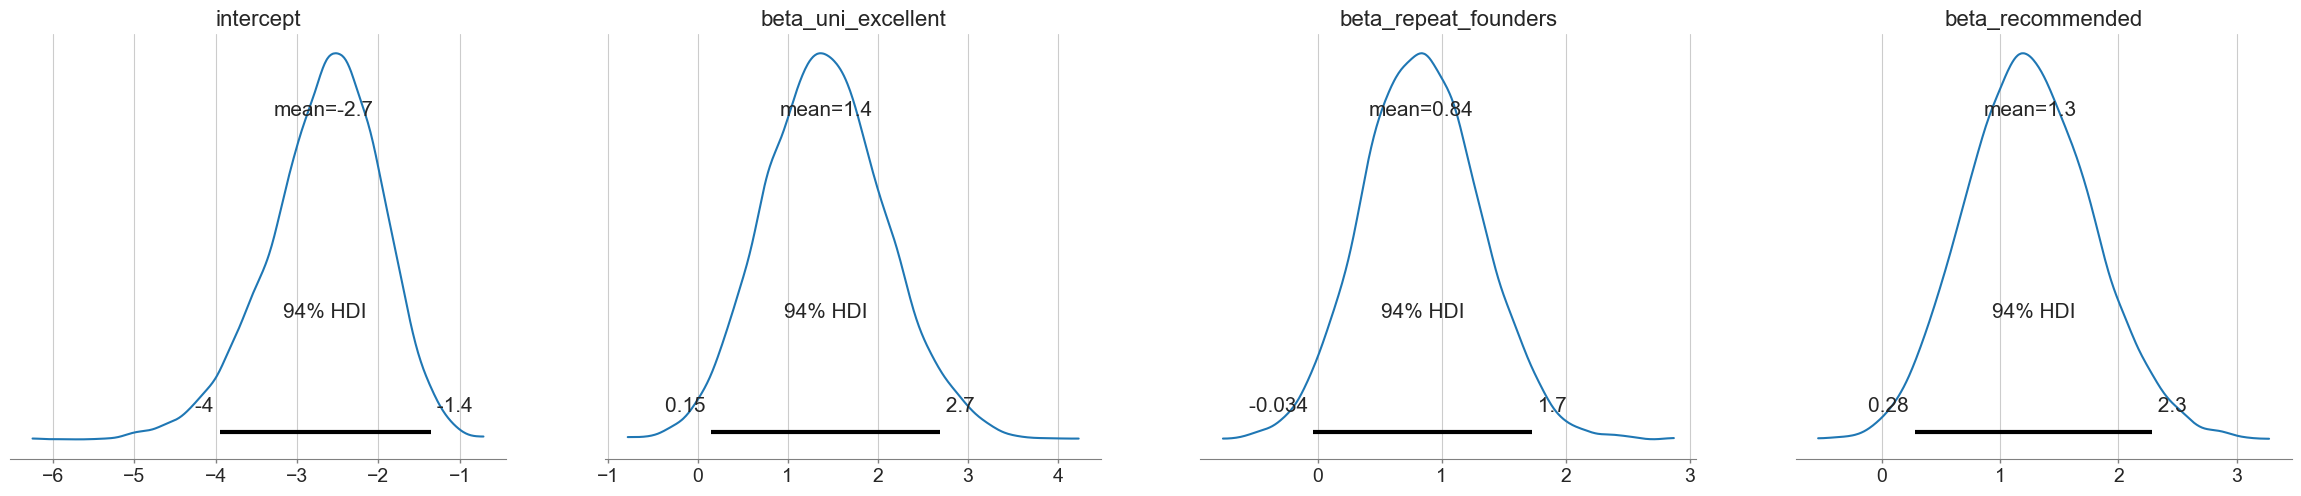

In [38]:

# For revenue model
az.plot_posterior(trace_rev, var_names=['intercept', 'beta_full_activity', 'beta_product_category', 'beta_uni_good_very_good'])
plt.show()

# For investment model
az.plot_posterior(trace_inv, var_names=['intercept', 'beta_uni_excellent', 'beta_repeat_founders', 'beta_recommended'])
plt.show()


In [39]:
# Strongly significant predictors: full_activity, product_category, and uni_excellent (since their HDIs do not include 0).

# Uncertain predictor: repeat_founders (since its HDI includes 0, meaning its effect could be negligible or even slightly negative).

# Intercept values vary, suggesting different baseline effects for different models or groups.

In [40]:
## Chosen oefficient Analysis and Inference: to understand which predictors are most important and reliable.

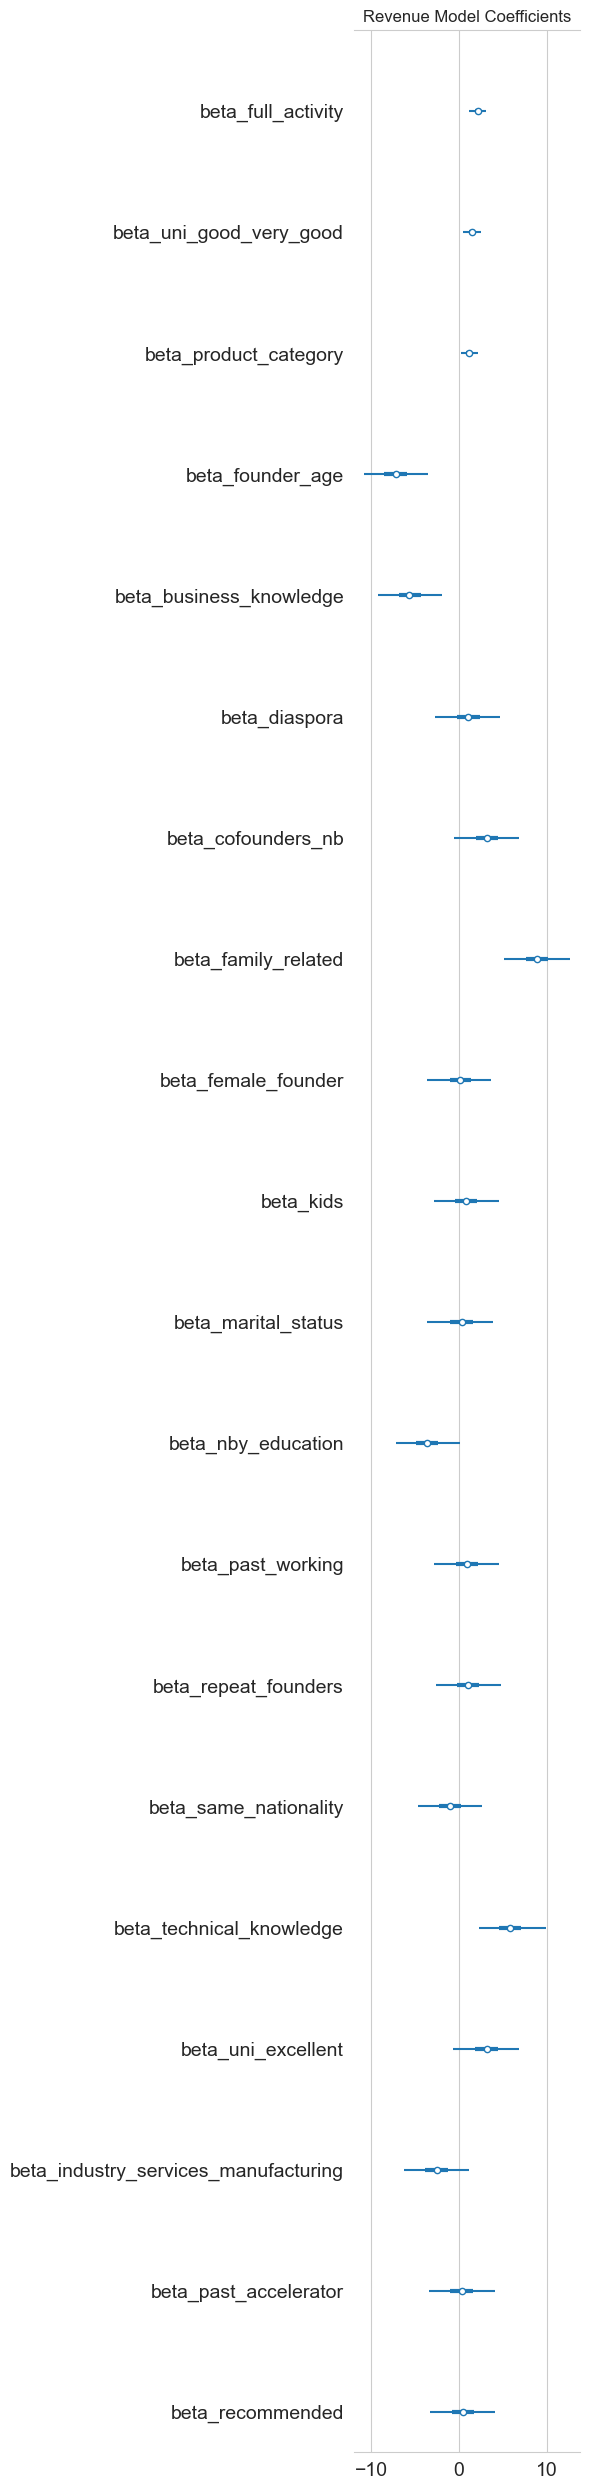

Probability that beta_full_activity coefficient > 0: 1.000
Probability that beta_uni_good_very_good coefficient > 0: 0.999
Probability that beta_product_category coefficient > 0: 0.991
Probability that beta_founder_age coefficient > 0: 0.000
Probability that beta_business_knowledge coefficient > 0: 0.002
Probability that beta_diaspora coefficient > 0: 0.711
Probability that beta_cofounders_nb coefficient > 0: 0.954
Probability that beta_family_related coefficient > 0: 1.000
Probability that beta_female_founder coefficient > 0: 0.536
Probability that beta_kids coefficient > 0: 0.658
Probability that beta_marital_status coefficient > 0: 0.558
Probability that beta_nby_education coefficient > 0: 0.029
Probability that beta_past_working coefficient > 0: 0.693
Probability that beta_repeat_founders coefficient > 0: 0.708
Probability that beta_same_nationality coefficient > 0: 0.298
Probability that beta_technical_knowledge coefficient > 0: 0.999
Probability that beta_uni_excellent coefficien

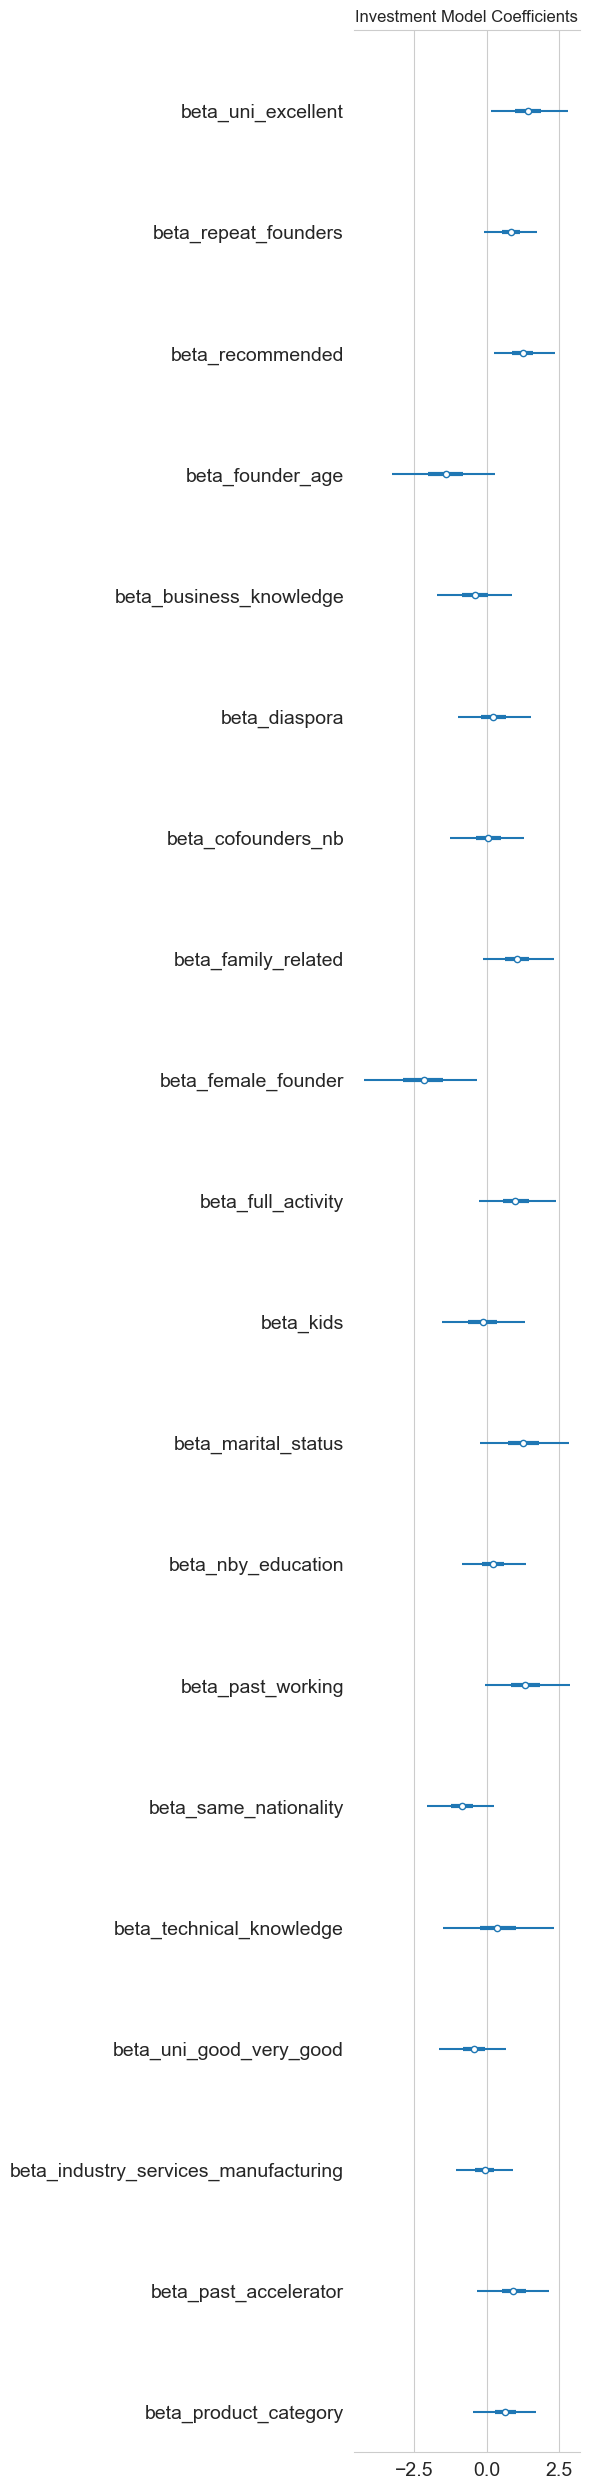

Probability that beta_uni_excellent coefficient > 0: 0.987
Probability that beta_repeat_founders coefficient > 0: 0.965
Probability that beta_recommended coefficient > 0: 0.994
Probability that beta_founder_age coefficient > 0: 0.041
Probability that beta_business_knowledge coefficient > 0: 0.269
Probability that beta_diaspora coefficient > 0: 0.640
Probability that beta_cofounders_nb coefficient > 0: 0.538
Probability that beta_family_related coefficient > 0: 0.961
Probability that beta_female_founder coefficient > 0: 0.009
Probability that beta_full_activity coefficient > 0: 0.945
Probability that beta_kids coefficient > 0: 0.421
Probability that beta_marital_status coefficient > 0: 0.951
Probability that beta_nby_education coefficient > 0: 0.654
Probability that beta_past_working coefficient > 0: 0.969
Probability that beta_same_nationality coefficient > 0: 0.059
Probability that beta_technical_knowledge coefficient > 0: 0.663
Probability that beta_uni_good_very_good coefficient > 0

In [41]:
import arviz as az
import matplotlib.pyplot as plt

# Function to plot forest plots and calculate probabilities for coefficients
def plot_forest_and_calc_probs(trace, model_type="Revenue"):
    # Define model-specific coefficients
    if model_type == "Revenue":
        beta_names = ['beta_full_activity', 'beta_uni_good_very_good', 'beta_product_category']
    elif model_type == "Investment":
        beta_names = ['beta_uni_excellent', 'beta_repeat_founders', 'beta_recommended']
    else:
        raise ValueError("Invalid model_type. Choose either 'Revenue' or 'Investment'.")

    # Add 'beta_other' dynamically based on available predictors
    other_predictors = [p for p in trace.posterior.keys() if p.startswith("beta_") and p not in beta_names]
    beta_names += other_predictors

    # Plot Forest Plot
    az.plot_forest(trace, var_names=beta_names, combined=True, hdi_prob=0.95)
    plt.title(f"{model_type} Model Coefficients")
    plt.tight_layout()
    plt.show()

    # Calculate and print probability that each coefficient is greater than zero
    for beta_name in beta_names:
        prob_greater_than_zero = (trace.posterior[beta_name] > 0).mean().values
        print(f"Probability that {beta_name} coefficient > 0: {prob_greater_than_zero:.3f}")

# Plot and calculate for Revenue Model
plot_forest_and_calc_probs(trace_rev, model_type="Revenue")

# Plot and calculate for Investment Model
plot_forest_and_calc_probs(trace_inv, model_type="Investment")


In [ ]:
## Predictive Performance Metrics: to assess how well the models perform on actual prediction tasks.

In [ ]:
## RMSE: 19.90 (high error)

## R²: -1966 ( poor fit)

## AUC: 0.9 (great discrimination ability)

## Accuracy: 0.8400 (solid overall performance)

## Precision: 0.8000 (80% of positive predictions are correct)

## Recall: 0.5714 (low recall,the model may  miss positive cases)